<a href="https://colab.research.google.com/github/Nivratti/Text_Classification/blob/master/Text_sentiment_analysis_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text sentiment analysis on Merged dataset (Twitter US airline + Amazon fine food reviews datset) --- Improved speed -- reducing matrix length

## Dataset info
Dataset is created by combining following two datsets:

1.  twitter-airline-sentiment:
https://www.kaggle.com/crowdflower/twitter-airline-sentiment

2.   amazon-fine-food-reviews:
https://www.kaggle.com/snap/amazon-fine-food-reviews

    Score mapping to sentiment label:

    *   1,2 ==> negative
    *   3   ==> neutral
    *   4,5 ==> positive


# Connect Google Colab with Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
time: 1.86 ms


## prevent-google-colab-from-disconnecting

Google Colab notebooks have an idle timeout of 90 minutes and absolute timeout of 12 hours. This means, if user does not interact with his Google Colab notebook for more than 90 minutes, its instance is automatically terminated. Also, maximum lifetime of a Colab instance is 12 hours.

Solution:

Set a javascript interval to click on the connect button every 60 seconds. Open developer-settings (in your web-browser) with Ctrl+Shift+I then click on console tab and type this on the console prompt. (for mac press Option+Command+I)

inser below code on console

```
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton, 1200000);
```




# Execution Time

In [0]:
!pip install ipython-autotime

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 14.5 s


# Tensorflow with GPU -- For faster training

Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

Navigate to Edit→Notebook Settings
select GPU from the Hardware Accelerator drop-down
Next, we'll confirm that we can connect to the GPU with tensorflow:

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0
time: 11.5 ms


# Global vars

In [0]:
import os

# project folder on rive containing dataset, trained model and other files
DRIVE_PROJECT_BASE_DIR = "/content/gdrive/My Drive/deep_learning/text_sentiment_analysis/"

if not os.path.exists(DRIVE_PROJECT_BASE_DIR):
    # check on root drive -- for shared folders -- Added shortcut for shared folders
    DRIVE_PROJECT_BASE_DIR = "/content/gdrive/My Drive/text_sentiment_analysis/"

BASE_DATASET_DIR = os.path.join(
    DRIVE_PROJECT_BASE_DIR , "dataset"
)

input_csv_path = os.path.join(
    BASE_DATASET_DIR , "twitter-amazon-combined-dataset.csv"
)

time: 5.58 ms


#  utils

## Pandas utils

In [0]:
import pandas as pd
import os
import sys


def read_file_as_df(file__path):
    """
    read file data using pandas
    
    Arguments:
        file__path {string} -- File with path
    
    Returns:
        DataFrame -- pandas.core.frame.DataFrame
    """
    # file__path -- file with path(double underscore)
    if os.path.exists(file__path):
        file_name, extension = os.path.splitext(
            file__path
        )
        if extension in [".xlsx", ".xls"]:
            df = pd.read_excel(file__path)

        elif extension in [".csv"]:
            df = pd.read_csv(file__path)

        else:
            error_msg = f"""
                Error .. Unsupported file type
                {extension} to read_file_data()
            """
            print(error_msg)
            return False

        return df
    else:
        error_msg = f"""
            Error ... File not exists with
            path {file__path}
        """
        print(error_msg)
        sys.exit(error_msg)

def is_columns_exists(df, columns):
    """
    check is columns exists in dataframe
    
    Arguments:
        df {[type]} -- [description]
        columns {[type]} -- [description]
    """
    all_exists = True
    for column in columns:
        if column in df.columns:
            pass
        else:
            all_exists = False
            print(
                f"Column not exists in dataframe"
            )
    return all_exists

def keep_only_req_columns(df, columns):
    """
    Keeping only the necessary/required columns
    
    Arguments:
        df {[type]} -- [description]
        columns {list} -- ['text','sentiment']
    
    Returns:
        [type] -- [description]
    """
    return df[columns]

def filter_dataframe_rows(data_frame, row_rules):
    """
    filter dataframe row data
    data_frame (diffrent name taken for argument because it is mutable
    changable type)
    
    Arguments:
        data_frame {[type]} -- [description]
        row_rules {[type]} -- [description]
    
    Returns:
        dataFrame -- modified dataframe

    input examples:
        row_rules = [{
            "rule" : 'keep_row_if_column_text_not_equal_to',
            "column_name": "text",
            "text": "Neutral"
        },
        {
            "rule" : 'drop_if_column_value_null',
            "column_name": "text",
            "drop": True
        }]
    """
    for rule_item in row_rules:
        rule = rule_item.get("rule")
        if 'keep_row_if_column_text_not_equal_to' == rule:
            column = rule_item['column_name']
            text = rule_item['text']
            
            data_frame = data_frame[
                data_frame[column] != text
            ]
        
        if 'drop_if_column_value_null' == rule:
            column = rule_item['column_name']
            data_frame = data_frame[
                data_frame[column].str.strip().astype(bool)
            ]
            
    return data_frame

def generate_df_from_mongo_cursor(cursor, remove_id=False):
    """
    [summary]
    
    Arguments:
        cursor {[type]} -- Result of record fetching
    """
    df = pd.DataFrame(
        list(cursor)
    )
    if remove_id:
        # delete the _id
        del df['_id']
    return df


time: 43.5 ms


# Load Packages

In [0]:
import matplotlib.pyplot as plt
from tensorflow.python.keras import models, layers, optimizers
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import bz2
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import re
import numpy as np
%matplotlib inline


time: 5.26 ms


# Read dataset and view its metadata

## Read dataset

In [0]:
#load data as dataframe
dataset = read_file_as_df(input_csv_path)

time: 2.46 s


## View info about dataframe

Number of rows and columns of data

In [0]:
print(f"Dataframe shape  : { dataset.shape }")

Dataframe shape  : (583094, 3)
time: 1.69 ms


Columns

In [0]:
print(f"Dataframe columns : \n{dataset.columns }")

Dataframe columns : 
Index(['Unnamed: 0', 'sentiment', 'text'], dtype='object')
time: 1.32 ms


Look at first 5 rows

In [0]:
dataset.head()

,Unnamed: 0,sentiment,text
0,0,neutral,what say
1,1,positive,plus have add commercial eerience tacky
2,2,neutral,do not today must mean need trip
3,3,negative,be aggressive blast obnoxious entertainment ...
4,4,negative,be big bad thing


time: 25.8 ms


rename columns

In [0]:
# dataset = dataset.rename(columns={"Sentiment": "sentiment"})
# dataset.head()

time: 609 µs


Checking whether there is any null values (for text and sentiment column)

In [0]:
dataset.isnull().sum()

Unnamed: 0     0
sentiment      0
text          22
dtype: int64

time: 105 ms


drop null review rows if exists

In [0]:
# drop null review rows
dataset = dataset[~dataset['text'].isnull()]

# after dropping null
dataset.isnull().sum()

sentiment    0
text         0
dtype: int64

time: 194 ms


view data per class

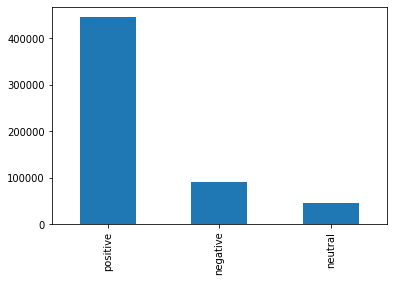

time: 204 ms


In [0]:
dataset["sentiment"].value_counts().plot.bar()

Keep only required columns

In [0]:
dataset = keep_only_req_columns(dataset, ["sentiment", "text"])

time: 29.9 ms


In [0]:
dataset.head()

,sentiment,text
0,neutral,what say
1,positive,plus have add commercial eerience tacky
2,neutral,do not today must mean need trip
3,negative,be aggressive blast obnoxious entertainment ...
4,negative,be big bad thing


time: 11 ms


# Text Preprocessing

The first thing I'm going to do to process the text is to lowercase everything and then remove non-word characters. I replace these with spaces since most are going to be punctuation. Then I'm going to just remove any other characters (like letters with accents). It could be better to replace some of these with regular ascii characters but I'm just going to ignore that here. It also turns out if you look at the counts of the different characters that there are very few unusual characters in this corpus.

## Preprocessor

Remove:
* URLs
* Hashtags
* Mentions
* Reserved words (RT, FAV)
* Emojis
* Smileys

In [0]:
!pip install tweet-preprocessor

time: 13.7 s


In [0]:
import preprocessor as p
print(p.clean('Preprocessor is #awesome 👍 https://github.com/s/preprocessor'))
print(p.clean("@peter I really love that shirt at #Macy. http://bet.ly//WjdiW4"))
# p.clean("Have questions about asteroid 1998 OR2, comet Borisov, or comet Atlas? Want to know more about these cosmic objects zipping through our solar system? Flushed faceComet Join us in an hour at 4pm ET on @reddit to chat with NASA scientists and experts about them! https://redd.it/g9o4yp")

Preprocessor is
I really love that shirt at .
time: 3.32 ms


## Removing stopwords

Stopwords are the most common words in any natural language. For the purpose of analyzing text data and building NLP models, these stopwords might not add much value to the meaning of the document.

```
Generally, the most common words used in a text are “the”, “is”, “in”, “for”, “where”, “when”, “to”, “at” etc.
```

In [0]:
from gensim.parsing.preprocessing import remove_stopwords

remove_stopwords("Better late than never, but better never late.")

'Better late never, better late.'

time: 3.47 ms


## Lemmatization

Lemmatization, is an organized & step-by-step procedure of obtaining the root form of the word. It makes use of vocabulary (dictionary importance of words) and morphological analysis (word structure and grammar relations).

In [0]:
import spacy
from pprint import pprint

spacy_nlp = spacy.load('en', disable=['parser', 'ner'])

def do_lemmatization(sentence):
  doc = spacy_nlp(sentence)

  lemmas = []
  for token in doc:
      if token.lemma_ != "-PRON-":
        lemmas.append(token.lemma_)

  return " ".join(lemmas)

time: 493 ms


In [0]:
sentence = """Following mice attacks, caring farmers were marching to Delhi for better living conditions. 
Delhi police on Tuesday fired water cannons and teargas shells at protesting farmers as they tried to 
break barricades with their cars, automobiles and tractors."""

print(do_lemmatization(sentence))

follow mice attack , care farmer be march to Delhi for well living condition . 
 Delhi police on Tuesday fire water cannon and teargas shell at protest farmer as try to 
 break barricade with car , automobile and tractor .
time: 14 ms


## Final Normalization

In [0]:
import re

NON_ALPHANUM = re.compile(r'[\W]')
NON_ASCII = re.compile(r'[^a-z0-1\s]')

def normalize_text(text):
    text = p.clean(text) # tweet preprocessor

    text = re.sub('\n{2,}', '\n', text) # replace multiple newlines with single
    text = text.replace("\t", " ") # replace tab with space
    text = re.sub(' {2,}', ' ', text) # convert multiple extra spaces to single

    text = remove_stopwords(text)
    text_lemmatization = do_lemmatization(text)
    lower = text_lemmatization.lower()

    # lower = text.lower()
    no_punctuation = NON_ALPHANUM.sub(r' ', lower)
    no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
    return no_non_ascii

time: 5.2 ms


In [0]:
dataset['text'] = dataset['text'].apply(normalize_text)

## Check max legth of text

In [0]:
counts = dataset["text"].value_counts()
print(f"Length of largest text: {max(counts)}")

Length of largest text: 199
time: 560 ms


## Truncate long texts -- otherwise later pad_sequences will consume large memory

In [0]:
# dataset['short_str'] = dataset['text'].str.slice(0,3)

# keep only 300 chars in single row
dataset['text'] = dataset['text'].str.slice(0, 300)


time: 387 ms


In [0]:
# out_file = "combined-normalized-twitter-amazon-dataset.csv"
# dataset.to_csv(out_file)
# !cp "$out_file" "$BASE_DATASET_DIR"

time: 1.05 ms


In [0]:
counts = dataset["text"].value_counts()
print(f"Length of largest text after truncate: {max(counts)}")

Length of largest text after truncate: 199
time: 543 ms


# Extract texts and labels from dataframe

In [0]:
texts = dataset["text"].values
labels = dataset["sentiment"].values

time: 2.01 ms


# Resampling Imbalanced datasets

https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

https://medium.com/@er.archiejain/balance-the-imbalanced-datasets-smote-810c2f13ce16

## under sampling

In [0]:
# from imblearn.under_sampling import RandomUnderSampler
# import numpy as np

# X = np.array(texts)
# y = labels

# # # make 2 da array first
# X = X.reshape(-1, 1)

# # random under sampling
# rus = RandomUnderSampler()
# X_rus, y_rus = rus.fit_sample(X, y)

# # # make 1D again
# X_rus = X_rus.flatten()

# data_sampling = "under-sampling"

time: 578 µs


In [0]:
# import pandas as pd
# import matplotlib.pyplot as plt

# pd.value_counts(y_rus).plot.bar()

# plt.xlabel('Class')
# plt.ylabel('Frequency')
# pd.value_counts(y_rus)

time: 694 µs


## Over sampling

In [0]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np

X = np.array(texts)
y = labels

# # make 2 da array first
X = X.reshape(-1, 1)

# random under sampling
rus = RandomOverSampler()
X_ros, y_ros = rus.fit_sample(X, y)

# # make 1D again
X_ros = X_ros.flatten()

data_sampling = "over-sampling"

time: 1.55 s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


positive    446138
negative    446138
neutral     446138
dtype: int64

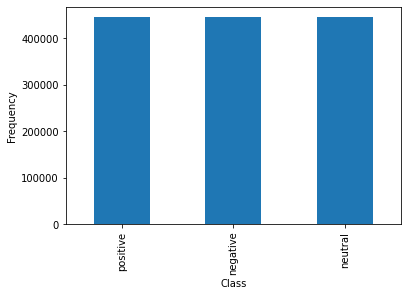

time: 387 ms


In [0]:
import pandas as pd
import matplotlib.pyplot as plt

pd.value_counts(y_ros).plot.bar()

plt.xlabel('Class')
plt.ylabel('Frequency')
pd.value_counts(y_ros)

## Assign Back

In [0]:
# # assign back
try:
  if data_sampling == "under-sampling":
    texts = X_rus.to_numpy()
    labels = y_rus
  elif data_sampling == "over-sampling":
    texts = X_ros.to_numpy()
    labels = y_ros
  else:
    pass
except:
  pass

time: 2.98 ms


# Encode labels (String to int)

In [0]:

# Keras expects an integer vector from 0 to num_classes. As it's stated in the docs:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
encoded_labels = labelencoder.fit_transform(labels)

# Print shapes
print("Shape of encoded_labels: {}".format(encoded_labels.shape))


Shape of encoded_labels: (1338414,)
time: 225 ms


In [0]:
classes = labelencoder.classes_
print(f'classes: {classes}')

classes: ['negative' 'neutral' 'positive']
time: 1.75 ms


In [0]:
num_classes = len(classes)
print("Total classes: {}".format(num_classes))

Total classes: 3
time: 1.46 ms


save label encoder

In [0]:
le_filename = "label_encoder_classes.npy"
np.save(le_filename, labelencoder.classes_)

## loading in test
# le = LabelEncoder()
# le.classes_ = numpy.load(le_filename)

time: 2.41 ms


# Train/Validation Split
Now I'm going to set aside 20% of the training set for validation.

In [0]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, encoded_labels, random_state=57692, test_size=0.2
)

time: 527 ms


In [0]:
print("Shape of train_labels: {}".format(train_labels.shape))
print("length of train_texts: {}".format(len(train_texts)))

print("Shape of val_labels: {}".format(val_labels.shape))
print("length of val_texts: {}".format(len(val_texts)))

Shape of train_labels: (1070731,)
length of train_texts: 1070731
Shape of val_labels: (267683,)
length of val_texts: 267683
time: 3.36 ms


viewing top 5 labels and first training text.

In [0]:
print(train_labels[:5])
print(train_texts[:1])

[1 0 2 0 1]
['do not huge problem dry scalp   hair dry think try out   do not   work fine normal cleaning   thick   dry   frizzy hair   do not great improvement use regular hair care product   aussie     be not fond scent either   be not strong bearable  ']
time: 2.78 ms


# Tokenization

Now I will just run a Tokenizer using the top 12000 words as features.

In [0]:
MAX_FEATURES = 12000
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(train_texts)
tokenizer.fit_on_texts(val_texts)

train_texts = tokenizer.texts_to_sequences(train_texts)
val_texts = tokenizer.texts_to_sequences(val_texts)

print(f"train_texts sample: {train_texts[0]} \n")

train_texts sample: [9, 2, 451, 119, 98, 1264, 389, 98, 23, 14, 184, 9, 2, 75, 194, 560, 2772, 843, 98, 6624, 389, 9, 2, 18, 1918, 32, 130, 389, 319, 10, 4146, 3, 2, 1680, 904, 426, 3, 2, 80, 4349] 

time: 1min 21s


# Padding Sequences
In order to use batches effectively, I'm going to need to take my sequences and turn them into sequences of the same length. I'm just going to make everything here the length of the longest sentence in the training set. I'm not dealing with this here, but it may be advantageous to have variable lengths so that each batch contains sentences of similar lengths. This might help mitigate issues that arise from having too many padded elements in a sequence.


In [0]:
MAX_LENGTH = max(len(train_ex) for train_ex in train_texts)
print(f"MAX_LENGTH: {MAX_LENGTH}")

train_texts = pad_sequences(train_texts, maxlen=MAX_LENGTH)
val_texts = pad_sequences(val_texts, maxlen=MAX_LENGTH)

print(f"train_texts sample: {train_texts[0]}")

MAX_LENGTH: 67
train_texts sample: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    9
    2  451  119   98 1264  389   98   23   14  184    9    2   75  194
  560 2772  843   98 6624  389    9    2   18 1918   32  130  389  319
   10 4146    3    2 1680  904  426    3    2   80 4349]
time: 8.59 s


In [0]:
import sys

print(sys.getsizeof(train_texts))
print(train_texts.shape)
print(train_texts.dtype)

286956020
(1070731, 67)
int32
time: 2.86 ms


# Save Tokenizer

In [0]:
import pickle

file_tokenizer = "tokenizer_info.pickle"

# saving
tokenizer_info = {
    "tokenizer"   : tokenizer,
    "MAX_LENGTH"  : MAX_LENGTH,
    "MAX_FEATURES": MAX_FEATURES,
}
with open(file_tokenizer, 'wb') as handle:
    pickle.dump(tokenizer_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

time: 83.6 ms


In [0]:
# copy to drive
!cp "$file_tokenizer" "$BASE_DATASET_DIR"

time: 3.3 s


In [0]:
# make some space
del tokenizer

import gc

print(f"total objects in memory --{gc.get_count()}")

# collecting memory
gc.collect()
print(f"After garbage collecor- objects in memory --{gc.get_count()}")

total objects in memory --(270, 4, 13)
After garbage collecor- objects in memory --(25, 0, 0)
time: 180 ms


# convert to categorical data

In [0]:
from keras.utils import to_categorical

train_y = to_categorical(train_labels, num_classes=num_classes, dtype='float32')
val_y = to_categorical(val_labels, num_classes=num_classes, dtype='float32')

# Print shapes
print("Shape of train_y: {}".format(train_y.shape))
print("Shape of val_y: {}".format(val_y.shape))

Shape of train_y: (1070731, 3)
Shape of val_y: (267683, 3)
time: 148 ms


Using TensorFlow backend.


view single record

In [0]:
print(train_y[0:3])

[0. 1. 0.]
time: 1.81 ms


# Deep learning Models

In [0]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,GRU,LSTM,Embedding, CuDNNLSTM, CuDNNGRU
from keras.optimizers import Adam
from keras.layers import SpatialDropout1D,Dropout,Bidirectional,Conv1D,GlobalMaxPooling1D,MaxPooling1D,Flatten
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D

time: 5.85 ms


## Utilities

### Plotting accuracy and loss graph

In [0]:
import matplotlib.pyplot as plt

def plot_accuracy_loss(history):
  axes = plt.axes()
  axes.set_ylim([0, 1])

  # Plot training & validation accuracy values
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  axes = plt.axes()
  # axes.set_ylim([0, 1])
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

time: 14.1 ms


## confusion matrix

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, yhat_classes, classes, figsize=(8,6), cmap="Blues"):
  conf_mat = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=figsize)
  sns.heatmap(conf_mat, annot=True, fmt='3.0f', cmap=cmap, xticklabels=classes, yticklabels=classes)
  plt.title('Confusion_matrix', y=1.05, size=15)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

time: 4.88 ms


## Accuracy, Precision score, Recall, F1-socre

In [0]:
# calculating metrics for a neural network model using sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

def calculate_extra_metrices(y_true, yhat_classes):
  # accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(y_true, yhat_classes)
  print('Accuracy: %f' % accuracy)
  # precision tp / (tp + fp)
  precision = precision_score(y_true, yhat_classes, average="weighted")
  print('Precision: %f' % precision)
  # recall: tp / (tp + fn)
  recall = recall_score(y_true, yhat_classes, average="weighted")
  print('Recall: %f' % recall)
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(y_true, yhat_classes, average="micro")
  print('F1 score: %f' % f1)

time: 11 ms


## LSTM

In [0]:
embed_dim = 256 # 64

model_LSTM = Sequential()
model_LSTM.add(Embedding(MAX_FEATURES, embed_dim, input_length=MAX_LENGTH,))
model_LSTM.add(LSTM(embed_dim)) # or LSTM(100)
model_LSTM.add(Dropout(0.2))
model_LSTM.add(Dense(num_classes, activation='softmax'))
model_LSTM.compile(loss = 'categorical_crossentropy', optimizer=Adam(lr = 0.001), metrics = ['acc'])
model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 67, 256)           3072000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 3,598,083
Trainable params: 3,598,083
Non-trainable params: 0
_________________________________________________________________
time: 9.19 s


### Callbacks

In [0]:
# Adding the callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_path = "lstm_model.best.hdf5"

# use early stopping to optimally terminate training through callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2) # patience=3)

# save best model automatically
mc = ModelCheckpoint(
    checkpoint_path, monitor='val_loss', 
    mode='min', verbose=1, save_best_only=True
)
cb_list = [es,mc]

time: 3.81 ms


### Train

In [0]:
# Train model
epochs = 25
batch_size = 4096 # 64 # use more if gpu available - for faster processing 
history = model_LSTM.fit(
    train_texts, train_y, 
    validation_data=(val_texts, val_y), 
    epochs=epochs, 
    batch_size=batch_size, 
    verbose=1, shuffle=True,
    callbacks=cb_list,
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1070731 samples, validate on 267683 samples
Epoch 1/25
1070731/1070731 [==============================] - 245s 229us/step - loss: 0.6788 - acc: 0.7073 - val_loss: 0.5639 - val_acc: 0.7723

Epoch 00001: val_loss improved from inf to 0.56393, saving model to lstm_model.best.hdf5
Epoch 2/25
1070731/1070731 [==============================] - 244s 228us/step - loss: 0.4984 - acc: 0.8034 - val_loss: 0.4551 - val_acc: 0.8239

Epoch 00002: val_loss improved from 0.56393 to 0.45507, saving model to lstm_model.best.hdf5
Epoch 3/25
1070731/1070731 [==============================] - 243s 227us/step - loss: 0.3878 - acc: 0.8540 - val_loss: 0.3614 - val_acc: 0.8652

Epoch 00003: val_loss improved from 0.45507 to 0.36139, saving model to lstm_model.best.hdf5
Epoch 4/25
1070731/1070731 [==============================] - 244s 228us/step - loss: 0.2971 - acc: 0.8926 - val_loss: 0.3190 - val_acc: 0.8862

Epoch 00004: val_loss improved from 0.36139 to 0.31903, saving model to lstm_model.best.hdf5

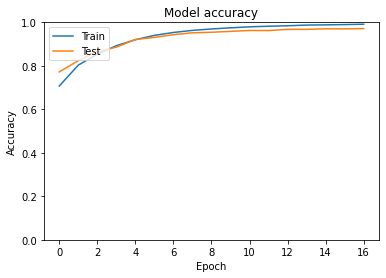

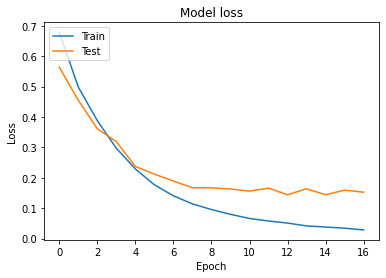

time: 378 ms


In [0]:
plot_accuracy_loss(history)

model metrices

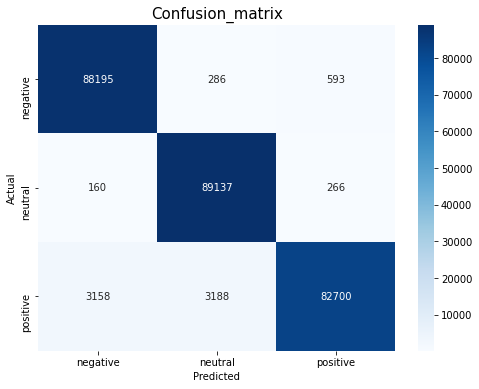




Accuracy: 0.971418
Precision: 0.971964
Recall: 0.971418
F1 score: 0.971418
time: 2min 5s


In [0]:
y_pred = model_LSTM.predict_classes(val_texts)
y_true = val_labels
plot_confusion_matrix(y_true=y_true, yhat_classes=yhat_classes, classes=classes)
print("\n\n")
calculate_extra_metrices(y_true=val_labels, yhat_classes=y_pred)

## Convolutional Neural Net Model

In [0]:
# set parameters:
filters = 250
kernel_size = 3
hidden_dims = 250

model_cnn = Sequential()

model_cnn.add(Embedding(MAX_FEATURES, embed_dim, input_length=MAX_LENGTH))
model_cnn.add(Dropout(0.2))

model_cnn.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model_cnn.add(GlobalMaxPooling1D())

model_cnn.add(Dense(hidden_dims))
model_cnn.add(Dropout(0.2))
model_cnn.add(Activation('relu'))

model_cnn.add(Dense(num_classes))
model_cnn.add(Activation('softmax'))

model_cnn.compile(loss = 'categorical_crossentropy', optimizer=Adam(lr = 0.001), metrics = ['acc'])

print(model_cnn.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 67, 256)           3072000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 67, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 65, 250)           192250    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_3 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 250)              

### Avoid wasting resources with EarlyStopping and ModelCheckpoint in Keras

Training a neural network can take a lot of time. In some cases, especially with 
very deep architectures trained on very large data sets, it can take weeks before one’s model 
is finally trained.

Unfortunately, setting a fixed number of epochs is often a bad idea. Here’s why:

1.   When you use too few epochs, your model will remain underfit. What I mean is that its predictive power can still be improved without a loss of generalization power (i.e., it improves without overfitting). You will end up with a model that does not perform at its maximum capability.

2.   When you use too many epochs, depending on how you configure the training process, your final model will either be optimized or it will be overfit. In both cases, you will have wasted resources. Hey, but why are those resources wasted when the final model is optimal? Simple – most likely, this optimum was found in e.g. 20% of the epochs you configured the model for. 80% of the resources you used are then wasted. Especially with highly expensive tasks in computational terms, you’ll want to avoid waste as much as you can.





In [0]:
# Adding the callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_path = "cnn_model.best.hdf5"

# use early stopping to optimally terminate training through callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1) # patience=3)

# save best model automatically
mc = ModelCheckpoint(
    checkpoint_path, monitor='val_loss', 
    mode='min', verbose=1, save_best_only=True
)
cb_list = [es,mc]

time: 6.51 ms


### Start training

In [0]:
# Train model
epochs = 25
batch_size = 4096 # 64 # use more if gpu available - for faster processing 
history = model_cnn.fit(
    train_texts, train_y,
    validation_data=(val_texts, val_y), 
    epochs=epochs, 
    batch_size=batch_size,
    verbose=1,shuffle=True,
    callbacks=cb_list,
    
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1070731 samples, validate on 267683 samples
Epoch 1/25
1070731/1070731 [==============================] - 92s 86us/step - loss: 0.5943 - acc: 0.7509 - val_loss: 0.3287 - val_acc: 0.8861

Epoch 00001: val_loss improved from inf to 0.32866, saving model to cnn_model.best.hdf5
Epoch 2/25
1070731/1070731 [==============================] - 87s 81us/step - loss: 0.2314 - acc: 0.9220 - val_loss: 0.1402 - val_acc: 0.9549

Epoch 00002: val_loss improved from 0.32866 to 0.14021, saving model to cnn_model.best.hdf5
Epoch 3/25
1070731/1070731 [==============================] - 87s 81us/step - loss: 0.1170 - acc: 0.9622 - val_loss: 0.0942 - val_acc: 0.9707

Epoch 00003: val_loss improved from 0.14021 to 0.09421, saving model to cnn_model.best.hdf5
Epoch 4/25
1070731/1070731 [==============================] - 87s 81us/step - loss: 0.0807 - acc: 0.9736 - val_loss: 0.0888 - val_acc: 0.9732

Epoch 00004: val_loss improved from 0.09421 to 0.08885, saving model to cnn_model.best.hdf5
Epoch 5/25


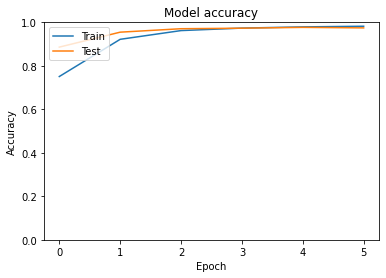

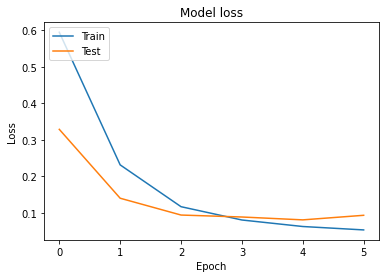

time: 351 ms


In [0]:
plot_accuracy_loss(history)

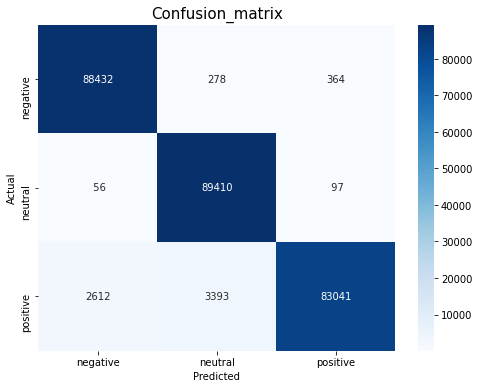




Accuracy: 0.974597
Precision: 0.975222
Recall: 0.974597
F1 score: 0.974597
time: 16.5 s


In [0]:
y_pred = model_cnn.predict_classes(val_texts)
y_true = val_labels
plot_confusion_matrix(y_true=y_true, yhat_classes=yhat_classes, classes=classes)
print("\n\n")
calculate_extra_metrices(y_true=val_labels, yhat_classes=y_pred)

## GRU

In [0]:
def build_gru_model():
    sequences = layers.Input(shape=(MAX_LENGTH,))
    embedded = layers.Embedding(MAX_FEATURES, 64)(sequences)
    x = layers.CuDNNGRU(128, return_sequences=True)(embedded)
    x = layers.CuDNNGRU(128)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(100, activation='relu')(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=sequences, outputs=predictions)
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['acc']
    )
    return model
    
gru_model = build_gru_model()

time: 243 ms


### Avoid wasting resources with EarlyStopping and ModelCheckpoint in Keras

Training a neural network can take a lot of time. In some cases, especially with 
very deep architectures trained on very large data sets, it can take weeks before one’s model 
is finally trained.

Unfortunately, setting a fixed number of epochs is often a bad idea. Here’s why:

1.   When you use too few epochs, your model will remain underfit. What I mean is that its predictive power can still be improved without a loss of generalization power (i.e., it improves without overfitting). You will end up with a model that does not perform at its maximum capability.

2.   When you use too many epochs, depending on how you configure the training process, your final model will either be optimized or it will be overfit. In both cases, you will have wasted resources. Hey, but why are those resources wasted when the final model is optimal? Simple – most likely, this optimum was found in e.g. 20% of the epochs you configured the model for. 80% of the resources you used are then wasted. Especially with highly expensive tasks in computational terms, you’ll want to avoid waste as much as you can.





In [0]:
# Adding the callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_path = "gru_model.best.hdf5"

# use early stopping to optimally terminate training through callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1) # patience=3)

# save best model automatically
mc = ModelCheckpoint(
    checkpoint_path, monitor='val_loss', 
    mode='min', verbose=1, save_best_only=True
)
cb_list = [es,mc]

time: 4.07 ms


### Train

In [0]:
epochs = 250
batch_size = 2048 # 128 # use more if gpu available - for faster processing 

history = gru_model.fit(
    train_texts, 
    train_y, 
    validation_data=(val_texts, val_y),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=cb_list,
)

Epoch 1/250
523/523 [==============================] - ETA: 0s - loss: 0.6713 - acc: 0.7140
Epoch 00001: val_loss improved from inf to 0.56291, saving model to gru_model.best.hdf5
523/523 [==============================] - 102s 195ms/step - loss: 0.6713 - acc: 0.7140 - val_loss: 0.5629 - val_acc: 0.7801
Epoch 2/250
523/523 [==============================] - ETA: 0s - loss: 0.4994 - acc: 0.8111
Epoch 00002: val_loss improved from 0.56291 to 0.45513, saving model to gru_model.best.hdf5
523/523 [==============================] - 101s 193ms/step - loss: 0.4994 - acc: 0.8111 - val_loss: 0.4551 - val_acc: 0.8297
Epoch 3/250
523/523 [==============================] - ETA: 0s - loss: 0.3993 - acc: 0.8539
Epoch 00003: val_loss improved from 0.45513 to 0.38349, saving model to gru_model.best.hdf5
523/523 [==============================] - 101s 192ms/step - loss: 0.3993 - acc: 0.8539 - val_loss: 0.3835 - val_acc: 0.8602
Epoch 4/250
523/523 [==============================] - ETA: 0s - loss: 0.3305

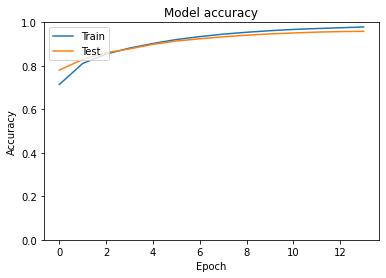

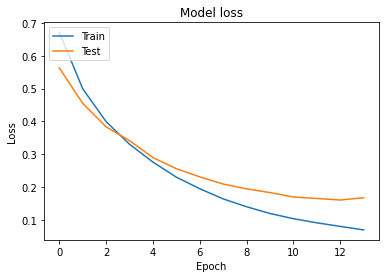

time: 357 ms


In [0]:
plot_accuracy_loss(history)

## Bidirectional-GRU

In [0]:
embed_dim = 64

def build_bidirectional_gru():
	model = Sequential()
	model.add(Embedding(MAX_FEATURES, embed_dim, input_length=MAX_LENGTH))
	model.add(SpatialDropout1D(0.25))
	model.add(Bidirectional(GRU(64,dropout=0.4, return_sequences = True)))
	model.add(Bidirectional(GRU(32,dropout=0.5, return_sequences = False)))
	model.add(Dense(num_classes, activation='softmax'))
	model.compile(
		loss = 'categorical_crossentropy', optimizer=Adam(lr = 0.001), 
		metrics = ['acc']
	)
	return model
	
bidirectional_gru_model = build_bidirectional_gru()

time: 683 ms


### Avoid wasting resources with EarlyStopping and ModelCheckpoint in Keras

Training a neural network can take a lot of time. In some cases, especially with 
very deep architectures trained on very large data sets, it can take weeks before one’s model 
is finally trained.

Unfortunately, setting a fixed number of epochs is often a bad idea. Here’s why:

1.   When you use too few epochs, your model will remain underfit. What I mean is that its predictive power can still be improved without a loss of generalization power (i.e., it improves without overfitting). You will end up with a model that does not perform at its maximum capability.

2.   When you use too many epochs, depending on how you configure the training process, your final model will either be optimized or it will be overfit. In both cases, you will have wasted resources. Hey, but why are those resources wasted when the final model is optimal? Simple – most likely, this optimum was found in e.g. 20% of the epochs you configured the model for. 80% of the resources you used are then wasted. Especially with highly expensive tasks in computational terms, you’ll want to avoid waste as much as you can.





In [0]:
# Adding the callbacks
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

checkpoint_path = "bidirectional_gru_model.best.hdf5"

# use early stopping to optimally terminate training through callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2) # patience=3)

# save best model automatically
mc = ModelCheckpoint(
    checkpoint_path, monitor='val_loss', 
    mode='min', verbose=1, save_best_only=True
)
cb_list = [es,mc]

time: 7.34 ms


### Train

In [0]:
epochs = 250
batch_size = 8192 # 128 # use more if gpu available - for faster processing 

history = bidirectional_gru_model.fit(
    train_texts, 
    train_y, 
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(val_texts, val_y),
    callbacks=cb_list,
)

Train on 1070731 samples, validate on 267683 samples
Epoch 1/25
1070731/1070731 [==============================] - 173s 161us/step - loss: 0.5934 - acc: 0.7647 - val_loss: 0.5643 - val_acc: 0.7816

Epoch 00001: val_loss improved from inf to 0.56429, saving model to bidirectional_gru_model.best.hdf5
Epoch 2/25
1070731/1070731 [==============================] - 173s 162us/step - loss: 0.5696 - acc: 0.7778 - val_loss: 0.5437 - val_acc: 0.7927

Epoch 00002: val_loss improved from 0.56429 to 0.54374, saving model to bidirectional_gru_model.best.hdf5
Epoch 3/25
1070731/1070731 [==============================] - 173s 161us/step - loss: 0.5477 - acc: 0.7895 - val_loss: 0.5219 - val_acc: 0.8042

Epoch 00003: val_loss improved from 0.54374 to 0.52188, saving model to bidirectional_gru_model.best.hdf5
Epoch 4/25
1070731/1070731 [==============================] - 172s 161us/step - loss: 0.5275 - acc: 0.7993 - val_loss: 0.5008 - val_acc: 0.8145

Epoch 00004: val_loss improved from 0.52188 to 0.5007

### Visualize

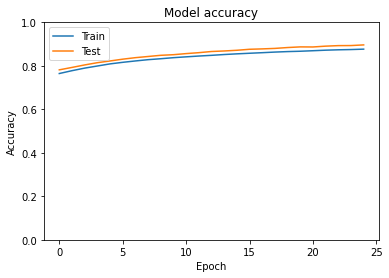

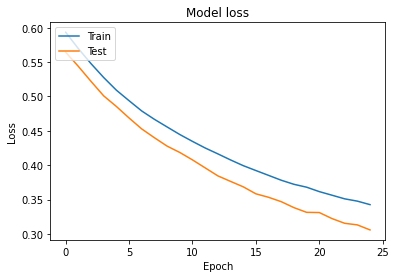

time: 362 ms


In [0]:
plot_accuracy_loss(history)

Model metrices

---



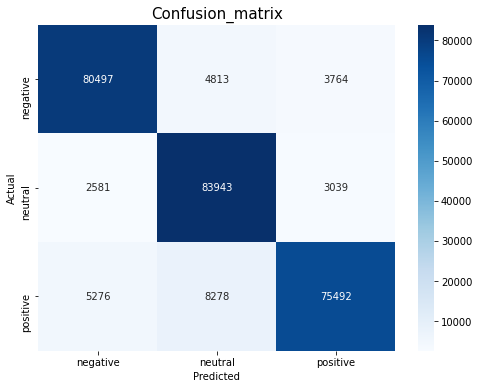

time: 462 ms


In [0]:
y_pred = bidirectional_gru_model.predict_classes(val_texts)
plot_confusion_matrix(val_labels, y_pred, classes)

In [0]:
calculate_extra_metrices(y_true=val_labels, yhat_classes=y_pred)

Accuracy: 0.896329
Precision: 0.897770
Recall: 0.896329
F1 score: 0.896329
time: 277 ms


## Save models to drive

In [0]:
BASE_OUTPUT_DIR = os.path.join(
    DRIVE_PROJECT_BASE_DIR , "output"
)
os.makedirs(BASE_OUTPUT_DIR, exist_ok=True)


time: 5.05 ms


In [0]:
!cp "lstm_model.best.hdf5" "$BASE_OUTPUT_DIR" 
!cp "cnn_model.best.hdf5" "$BASE_OUTPUT_DIR"
!cp "gru_model.best.hdf5" "$BASE_OUTPUT_DIR"

!cp "tokenizer_info.pickle" "$BASE_OUTPUT_DIR"
!cp "$le_filename" "$BASE_OUTPUT_DIR"

time: 2.58 s


# Machine learning

In [0]:
# add over sampled data
X = X_ros
y = y_ros

In [0]:
from sklearn.preprocessing import LabelEncoder  

le = LabelEncoder()
# convert not-integer labels to int
encoded_y = le.fit_transform(y)
print(encoded_y)

[1 2 1 ... 2 2 2]
time: 112 ms


In [0]:
classes = le.classes_

print(f'classes: {classes}')

classes: ['negative' 'neutral' 'positive']
time: 1.2 ms


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, encoded_y, test_size = 0.20, random_state = 0)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (466457,)
X_test shape: (116615,)
y_train shape: (466457,)
y_test shape: (116615,)
time: 68 ms


In [0]:

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Tokenize - Convert a collection of text documents to a matrix of token counts
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)


# Transform a count matrix to a normalized tf or tf-idf representation
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# test data
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

time: 15.8 s


## MultinomialNB

In [0]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

time: 188 ms


In [0]:
y_hat = clf.predict(X_test_tfidf)
# print(y_hat) # 'satisfied'

time: 31.6 ms


In [0]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_hat)

0.7984564592891138

time: 7.81 ms


In [0]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.83      0.22      0.34     18149
           1       0.63      0.01      0.01      8985
           2       0.80      1.00      0.89     89481

    accuracy                           0.80    116615
   macro avg       0.75      0.41      0.41    116615
weighted avg       0.79      0.80      0.73    116615

time: 130 ms


In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

time: 34.1 ms


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 1.05, 'Confusion_matrix')

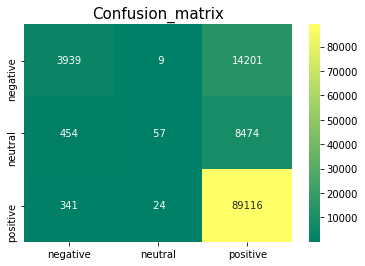

time: 338 ms


In [0]:
sns.heatmap(confusion_matrix(y_test, y_hat),annot=True, fmt='3.0f', cmap="summer", xticklabels=classes, yticklabels=classes)
plt.title('Confusion_matrix', y=1.05, size=15)

## LinearSVC

Accuracy : 0.86492303734511


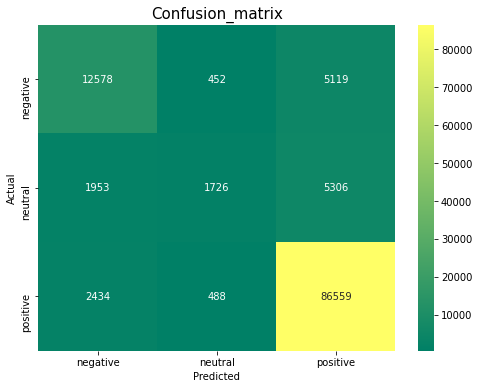

time: 24.6 s


In [0]:
from sklearn.svm import LinearSVC

model = LinearSVC()
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

print(f"Accuracy : {accuracy_score(y_test, y_pred)}")

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='3.0f', cmap="summer", xticklabels=classes, yticklabels=classes)
plt.title('Confusion_matrix', y=1.05, size=15)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## LogisticRegression

Accuracy : 0.8598036273206706


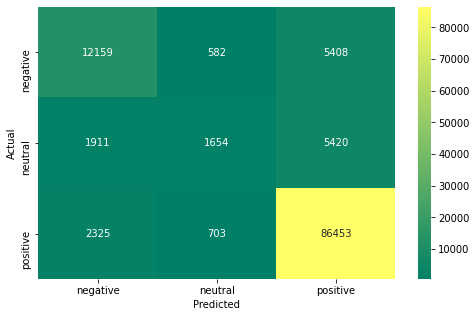

time: 4min 8s


In [0]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

print(f"Accuracy : {accuracy_score(y_test, y_pred)}")

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="summer", xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()